In [2]:
# NOTE: text aggregation

# group by user, and then do aggregation

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from lib.log import logger
from src.utils import load_pickle, save_pickle

2022-09-25 10:02:34,837 Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-09-25 10:02:34,838 NumExpr defaulting to 8 threads.
2022-09-25 02:02:35.608947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Tweets Group By User

n_clusters = 45
doc2topic = load_pickle(f"doc2topic/doc_topic_01_k{n_clusters}_maxiter50.p")

start_ids = load_pickle("../../dataset/start_ids.p")

In [26]:
last = 0
for start_id in start_ids[1:]+[60536760]:
    sample_tweet_feats = doc2topic[last:start_id]
    last = start_id
    break

In [28]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

batch_size = 100

# ~3min
# km  = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, verbose=0)
# km.fit(doc2topic)
# km_centers = km.cluster_centers_
# km_labels  = pairwise_distances_argmin(doc2topic, km_centers)

logger.info("start")
mbk = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", batch_size=batch_size, n_init=10, max_no_improvement=10, verbose=0)
mbk.fit(sample_tweet_feats)
mbk_centers = mbk.cluster_centers_
mbk_labels  = pairwise_distances_argmin(sample_tweet_feats, mbk_centers)
logger.info("finish fitting...")

2022-09-25 10:17:37,359 start
2022-09-25 10:17:37,518 finish fitting...


In [52]:
np.concatenate((mbk_labels, [45]*45))

array([31, 14, 28,  4,  2,  2,  2, 36,  4,  3,  5, 19,  6, 31,  2,  5, 36,
        2, 31, 27, 21,  7, 23, 23, 29,  2, 25,  2, 16, 36,  2,  2, 43, 41,
        8, 24,  2,  3, 37, 23, 23, 23, 14,  2, 11,  2,  2,  4,  0,  8,  4,
       15, 31, 32,  5, 22,  4,  3, 41,  2,  2,  5,  3,  8,  3,  2, 20, 14,
       21, 15, 40, 39, 23, 15, 14, 44,  2,  5, 23, 24, 15, 31,  2,  2,  5,
        2, 10,  3, 28, 27, 12,  7, 36, 34, 34,  2, 44, 14, 14,  5, 13,  7,
       19,  3,  6, 30,  7, 29,  3,  8,  2,  7,  2,  2,  7, 18, 23, 32, 11,
       33, 18,  7,  2, 15, 11, 10,  2,  4, 15, 26, 23,  2, 38, 19,  4, 14,
       10, 38, 29,  1,  2, 15,  2,  3,  4,  5,  2,  2, 43, 41, 32, 35, 30,
        2, 12, 13,  2, 19, 25, 34,  2, 31,  2, 29, 36,  7,  8,  3,  5, 39,
       36,  2, 42,  5,  9,  9,  9, 18,  7,  2,  2, 17,  4, 39,  5,  5,  2,
       11,  2,  3,  7, 14, 14, 14, 13,  2, 25, 21, 25, 36, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45

In [45]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, verbose=1)

data = np.concatenate((sample_tweet_feats, mbk_centers))
data_tsne = tsne.fit_transform(data)
# doc2topic_tsne   = tsne.fit_transform(sample_tweet_feats)

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# doc2topic_pca = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(doc2topic))

/root/.local/share/virtualenvs/Heter-GAT-afYRWUpf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/.local/share/virtualenvs/Heter-GAT-afYRWUpf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 245 samples in 0.001s...
[t-SNE] Computed neighbors for 245 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 245 / 245
[t-SNE] Mean sigma: 0.217553
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.227242
[t-SNE] KL divergence after 1000 iterations: 0.718045


<AxesSubplot: xlabel='x', ylabel='y'>

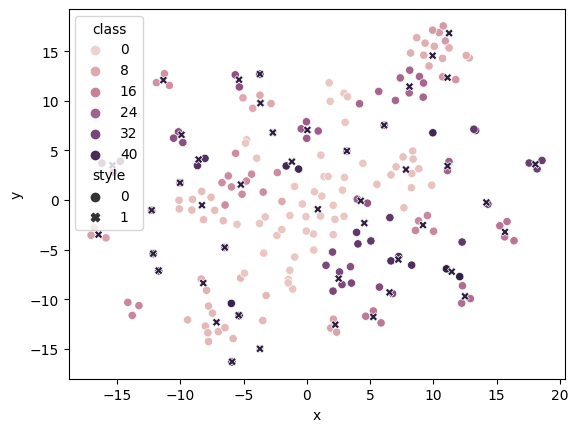

In [54]:
import seaborn as sns
import pandas as pd
import numpy as np

# selected_indices = np.random.choice(range(len(doc2topic_tsne)), size=20, replace=False)

df_ = pd.DataFrame({
    "x": data_tsne[:, 0],
    "y": data_tsne[:, 1],
    # "x": doc2topic_tsne[:,0],
    # "y": doc2topic_tsne[:,1],
    # "x": doc2topic_pca[:,0],
    # "y": doc2topic_pca[:,1],
    # "class": km_labels,
    # "class": mbk_labels,
    "class": np.concatenate((mbk_labels, [45]*45)),
    "style": np.array([0]*200+[1]*45),
    # "style": [1 if elem in selected_indices else 0 for elem in range(len(doc2topic_tsne))],
})

# NOTE: O: centers(colors are the most black), X: scatters
# 4min25.3s
sns.scatterplot(data=df_, hue="class", x="x", y="y", style="style")

In [ ]:
# import pyLDAvis.sklearn

# for idx in range(2, 11):
#     name = f"_0{idx}_k{45}_maxiter{50}"

#     model = load_pickle(f"model/model{name}.p")
#     dtm   = load_pickle(f"dtm/dtm{name}.p")
#     cv    = load_pickle(f"cv/cv{name}.p")

#     panel = pyLDAvis.sklearn.prepare(model, dtm, cv, mds='tsne') # Create the panel for the visualization
#     pyLDAvis.save_html(panel, f'LDAvis{name}.html')
#     logger.info("Finish Saving to html...")


In [ ]:
# NOTE: Kmeans + Mini-Batching

# import numpy as np
# from sklearn.datasets import make_blobs
# import time
# from sklearn.cluster import KMeans, MiniBatchKMeans

# np.random.seed(0)

# batch_size = 45
# centers = [[1, 1], [-1, -1], [1, -1]]
# n_clusters = len(centers)
# X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
# t0 = time.time()
# k_means.fit(X)
# t_batch = time.time() - t0
# logger.info(f"Time Consuming in Kmeans: {t_batch}")

# mbk = MiniBatchKMeans(
#     init="k-means++",
#     n_clusters=3,
#     batch_size=batch_size,
#     n_init=10,
#     max_no_improvement=10,
#     verbose=0,
# )
# t0 = time.time()
# mbk.fit(X)
# t_mini_batch = time.time() - t0
# logger.info(f"Time Consuming in Mini-Batch Kmeans: {t_mini_batch}")

# from sklearn.metrics.pairwise import pairwise_distances_argmin

# k_means_cluster_centers = k_means.cluster_centers_
# order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
# mbk_means_cluster_centers = mbk.cluster_centers_[order]

# k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
# mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(8, 3))
# fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
# colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# # KMeans
# ax = fig.add_subplot(1, 3, 1)
# for k, col in zip(range(n_clusters), colors):
#     my_members = k_means_labels == k
#     cluster_center = k_means_cluster_centers[k]
#     ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
#     ax.plot(
#         cluster_center[0],
#         cluster_center[1],
#         "o",
#         markerfacecolor=col,
#         markeredgecolor="k",
#         markersize=6,
#     )
# ax.set_title("KMeans")
# ax.set_xticks(())
# ax.set_yticks(())
# plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# # MiniBatchKMeans
# ax = fig.add_subplot(1, 3, 2)
# for k, col in zip(range(n_clusters), colors):
#     my_members = mbk_means_labels == k
#     cluster_center = mbk_means_cluster_centers[k]
#     ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
#     ax.plot(
#         cluster_center[0],
#         cluster_center[1],
#         "o",
#         markerfacecolor=col,
#         markeredgecolor="k",
#         markersize=6,
#     )
# ax.set_title("MiniBatchKMeans")
# ax.set_xticks(())
# ax.set_yticks(())
# plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# # Initialize the different array to all False
# different = mbk_means_labels == 4
# ax = fig.add_subplot(1, 3, 3)

# for k in range(n_clusters):
#     different += (k_means_labels == k) != (mbk_means_labels == k)

# identic = np.logical_not(different)
# ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
# ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
# ax.set_title("Difference")
# ax.set_xticks(())
# ax.set_yticks(())

# plt.show()